In [1]:
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from fastai.vision.all import *
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import csv

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34

from google.colab.patches import cv2_imshow

# We don't like warnings
import warnings
warnings.filterwarnings('ignore')

from urllib.request import urlopen

In [3]:
#https://walkwithfastai.com/Multi_Label
df = pd.read_csv('train.csv')
not_in_data = []
for i, row in df.iterrows():
  if not os.path.isfile(f'images/{row.image_id}'):
    not_in_data.append(row.image_id)

df = df[~df.image_id.isin(not_in_data)]

In [4]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  get_x=ColReader(0, pref='images/'),
                  splitter=RandomSplitter(seed=1111),
                  get_y=ColReader(1, label_delim=' '),
                  item_tfms=Resize(600),
                  batch_tfms = batch_tfms)

In [5]:
dls = db.dataloaders(df, bs=32)

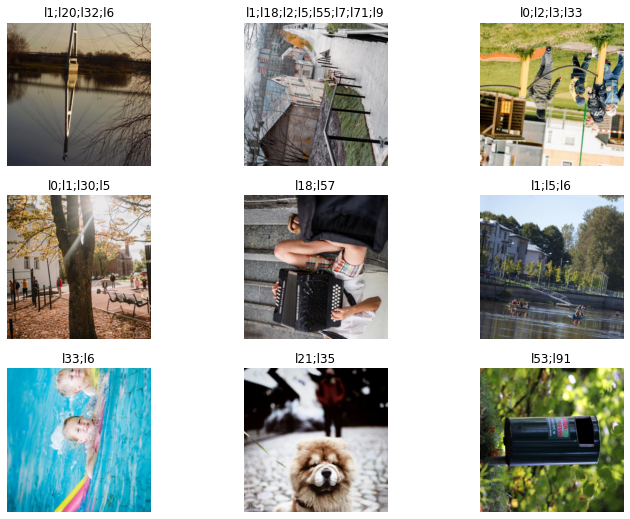

In [6]:
dls.show_batch(max_n=9, figsize=(12,9))

In [7]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])

In [8]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [9]:
learn.loss_func = BCEWithLogitsLossFlat()

SuggestedLRs(valley=0.0030199517495930195)

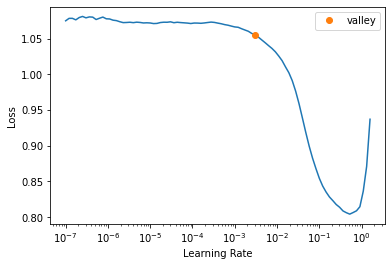

In [10]:
learn.lr_find()

In [11]:
lr = 0.005
#learn = learn.to_fp16()

In [12]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.062213,1.051867,0.473370,00:06
1,1.039609,0.877044,0.491848,00:06
2,1.006006,0.795497,0.525000,00:06
3,0.962511,0.717088,0.589402,00:06
4,0.909419,0.624659,0.661685,00:06
5,0.852452,0.532403,0.757609,00:06
6,0.792717,0.462946,0.823913,00:06
7,0.740108,0.410948,0.861685,00:06
8,0.695118,0.385193,0.884783,00:06
9,0.655487,0.376400,0.894837,00:06


In [13]:
#learn.save('stage-1')

In [14]:
#learn.unfreeze()
#learn.lr_find()

In [15]:
#learn.fit_one_cycle(5, slice(0.002, lr/5))

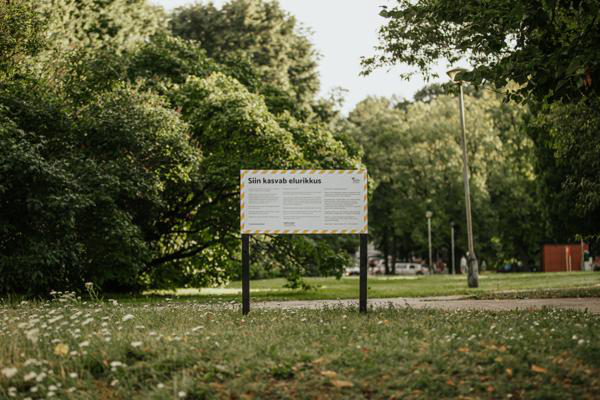

In [23]:
img = load_image('images/img102.jpg')
img

In [24]:
for i in learn.predict('images/img102.jpg')[0]:
  print(i) 

l24
l39


In [52]:
df_test = pd.read_csv('test.csv')
df_test

,image_id
0,img102.jpg
1,img103.jpg
2,img11.jpg
3,img113.jpg
4,img114.jpg
...,...
83,img81.jpg
84,img84.jpg
85,img90.jpg
86,img93.jpg


In [53]:
not_in_data = []
for i, row in df_test.iterrows():
  if not os.path.isfile(f'images/{row.image_id}'):
    not_in_data.append(row.image_id)

df_test = df_test[~df_test.image_id.isin(not_in_data)]

In [54]:
not_in_data

[]

In [55]:
test_labels = []
for i in df_test.image_id:
  test_labels.append(" ".join(learn.predict(f'images/{i}')[0]))

In [41]:
len(test_labels)

86

In [56]:
df_test.insert(1, "labels", test_labels, True)
df_test

,image_id,labels
0,img102.jpg,l24 l39
1,img103.jpg,l1 l10 l13 l16 l2 l22 l28 l3 l30 l5 l60 l7 l74
2,img11.jpg,l11 l16 l3 l35 l38 l4 l42 l5 l50 l91
3,img113.jpg,l10 l17 l57 l6
4,img114.jpg,l10 l13 l41 l58
...,...,...
83,img81.jpg,l10 l13 l21 l28 l31 l6 l62 l64 l77 l8
84,img84.jpg,l10 l13 l31 l38 l6 l68 l77 l78 l82
85,img90.jpg,l13 l60 l69 l86
86,img93.jpg,l10 l13 l25 l36 l41 l44 l48 l50 l51 l52 l69 l70 l72 l80 l82 l83


In [57]:
df_test.to_csv('out.csv', index=False)

In [46]:
from google.colab import files

files.upload();

Saving kaggle.json to kaggle.json


In [47]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [58]:
!kaggle competitions submit -c tartu-object-detection-part-2 -f out.csv -m "First predictions"

100% 3.60k/3.60k [00:00<00:00, 5.82kB/s]
Successfully submitted to Object recognition for The Image Bank of Tartu (2)